In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import talib
from sklearn.model_selection import train_test_split

In [2]:
data=yf.download('0005.hk','2018-01-01','2022-04-09')
# data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,80.550003,81.300003,80.449997,81.300003,69.135620,37060582
2018-01-03,81.300003,81.449997,80.800003,80.949997,68.837982,21680762
2018-01-04,80.900002,81.050003,80.349998,80.500000,68.455315,17205111
2018-01-05,81.050003,81.199997,80.599998,80.800003,68.710426,15902273
2018-01-08,80.500000,80.800003,80.050003,80.500000,68.455315,21354440
...,...,...,...,...,...,...
2022-04-01,53.700001,54.349998,53.400002,54.349998,54.349998,8177523
2022-04-04,54.299999,54.349998,53.799999,54.049999,54.049999,10779509
2022-04-06,53.900002,54.049999,53.150002,53.700001,53.700001,17097274


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
target=data['Prediction']

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_66886/3979859450.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    3.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.0s finished

[2022-04-13 19:47:15] Features: 1/1 -- score: 0.6825039812894231

SequentialFeatureSelector(estimator=RandomForestRegressor(), n_jobs=-1,
                          scoring='r2', verbose=2)

In [5]:
# data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=target
data_val=data[-100:]
data=data[:-100]
sc = MinMaxScaler(feature_range = (-1, 1))
# X=sc.fit_transform(data.drop('Prediction',1))
X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(735, 1) (735,) (184, 1) (184,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_66886/1151953013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=target
/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_66886/1151953013.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop('Prediction',1).values


In [6]:
clf = RandomForestRegressor()

In [7]:
model = clf.fit(X_train, y_train)

In [8]:
y_pred=model.predict(X_test)

In [9]:
y_pred

array([42.53200024, 45.92199997, 44.87725044, 45.47525066, 45.21925102,
       45.45325062, 45.49025063, 45.45325062, 46.16800087, 46.16800087,
       45.45325062, 44.86566603, 45.21925102, 45.45325062, 45.45325062,
       45.63300072, 48.3195015 , 46.55250099, 45.47525066, 44.93725029,
       44.87725044, 44.87725044, 45.21925102, 45.45325062, 46.16800087,
       45.21925102, 45.1342506 , 45.17471608, 42.58148313, 44.77075715,
       42.58148313, 45.17471608, 45.21925102, 44.86566603, 45.1342506 ,
       45.45325062, 45.47525066, 45.45325062, 45.45325062, 45.21925102,
       45.21925102, 45.1342506 , 45.21925102, 45.45325062, 44.77075715,
       44.77075715, 42.60248312, 43.64563429, 44.77075715, 46.16800087,
       46.55250099, 48.3195015 , 47.96850136, 45.63300072, 46.55250099,
       48.3195015 , 47.3520015 , 47.3520015 , 47.3520015 , 46.55250099,
       46.55250099, 48.41650146, 48.5995015 , 48.5995015 , 48.41650146,
       48.3195015 , 48.41650146, 48.3195015 , 48.3195015 , 48.41

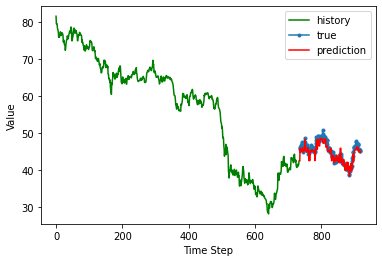

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
mean_absolute_percentage_error(y_test,y_pred)

0.021478910287760052

In [12]:
mean_squared_error(y_test,y_pred)

1.5166536478420238

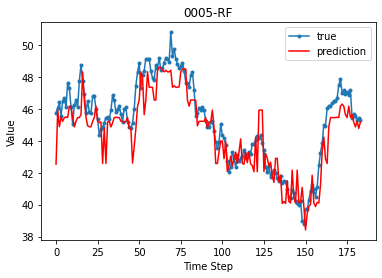

In [22]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('0005-RF')
plt.legend()
plt.show()

In [23]:
mean_absolute_percentage_error(y_test,y_pred)

0.021478910287760052

In [24]:
mean_squared_error(y_test,y_pred,squared=False)

1.231524927819987

In [25]:
r2_score(y_test,y_pred)

0.7798391438295408

In [17]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
# x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=clf.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_66886/2115332834.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


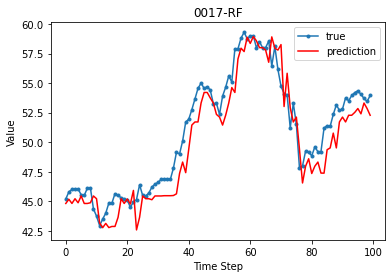

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('0017-RF')
plt.legend()
plt.show()

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.026560769747062167

In [20]:
mean_squared_error(y_val,y_val_pred,squared=False)

1.6428938161288094

In [21]:
r2_score(y_val,y_val_pred)

0.8777939301324232